# **Kaggle Playground Series - Season 5, Episode 2**

## **Objective**  
In this episode we are given the task of predict the price of backpacks given various attributes.

## **Data**  
The dataset for this competition is generated from a deep learning model trained on the [Student Bag Pric Preditions Dateset](https://www.kaggle.com/datasets/souradippal/student-bag-price-prediction-dataset/data)


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
print('Libaires imported')

Libaires imported


In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
df_train_ex = pd.read_csv('/kaggle/input/playground-series-s5e2/training_extra.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')
df_sub = pd.read_csv('/kaggle/input/playground-series-s5e2/sample_submission.csv')
print('Data imported')

Data imported


### **Initial Observations**  


In [3]:
df_test

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953
...,...,...,...,...,...,...,...,...,...,...
199995,499995,Adidas,Canvas,Large,2.0,Yes,No,Messenger,Red,7.383498
199996,499996,Nike,Polyester,Small,9.0,No,Yes,Messenger,Pink,6.058394
199997,499997,Jansport,Nylon,Small,9.0,No,Yes,Tote,Green,26.890163
199998,499998,Puma,Nylon,Large,10.0,Yes,No,Tote,Gray,25.769153


In [4]:
df_train

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364
299998,299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,115.89080


In [5]:
df_train_ex

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
1,500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
2,500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
3,500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
4,500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461
...,...,...,...,...,...,...,...,...,...,...,...
3694313,4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
3694314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
3694315,4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470
3694316,4194316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339,22.32269


In [6]:
df_train_combined = pd.concat([df_train, df_train_ex], ignore_index=True)

In [7]:
df_train_combined

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
3994313,4194313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
3994314,4194314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
3994315,4194315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470
3994316,4194316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339,22.32269


In [8]:
df_train = df_train_combined

### **Summary of Datasets**

In [9]:
missing_values_train = pd.DataFrame({'Feature': df_train.columns,
                              '[TRAIN] No. of Missing Values': df_train.isnull().sum().values,
                              '[TRAIN] % of Missing Values': ((df_train.isnull().sum().values)/len(df_train)*100)})

missing_values_test = pd.DataFrame({'Feature': df_test.columns,
                             '[TEST] No.of Missing Values': df_test.isnull().sum().values,
                             '[TEST] % of Missing Values': ((df_test.isnull().sum().values)/len(df_test)*100)})

unique_values = pd.DataFrame({'Feature': df_train.columns,
                              'No. of Unique Values[FROM TRAIN]': df_train.nunique().values})

feature_types = pd.DataFrame({'Feature': df_train.columns,
                              'DataType': df_train.dtypes})

df_summary = pd.merge(missing_values_train, missing_values_test, on='Feature', how='left')
df_summary = pd.merge(df_summary, unique_values, on='Feature', how='left')
df_summary = pd.merge(df_summary, feature_types, on='Feature', how='left')

df_summary

,Feature,[TRAIN] No. of Missing Values,[TRAIN] % of Missing Values,[TEST] No.of Missing Values,[TEST] % of Missing Values,No. of Unique Values[FROM TRAIN],DataType
0,id,0,0.000000,0.0,0.0000,3994318,int64
1,Brand,126758,3.173458,6227.0,3.1135,5,object
2,Material,110962,2.777996,5613.0,2.8065,4,object
3,Size,87785,2.197747,4381.0,2.1905,3,object
4,Compartments,0,0.000000,0.0,0.0000,10,float64
5,Laptop Compartment,98533,2.466829,4962.0,2.4810,2,object
6,Waterproof,94324,2.361454,4811.0,2.4055,2,object
7,Style,104180,2.608205,5153.0,2.5765,3,object
8,Color,133617,3.345177,6785.0,3.3925,6,object
9,Weight Capacity (kg),1808,0.045264,77.0,0.0385,1920345,float64


In [10]:
train_duplicates = df_train.duplicated().sum()
test_duplicates = df_test.duplicated().sum()

print(f"Number of duplicate rows in df_train: {train_duplicates}")
print(f"Number of duplicate rows in df_test: {test_duplicates}")

Number of duplicate rows in df_train: 0
Number of duplicate rows in df_test: 0


## **Dataset Observations**

### **Shape**
Training Data: 3,994,318rows × 11 columns  
Test Data: 200,000 rows × 10 columns

### **Missing Values**
Several features contain missing values in both the training and test sets:  

**Training set**
- Brand: ~3.17%
- Material:  ~2.78%
- Size: ~2.20%
- Laptop Compartment: ~2.47%
- Waterproof: ~2.36%
- Style: ~2.61%
- Color: ~3.35%
- Weight Capacity (kg): ~0.05%

**Test set**
- Brand: ~3.11%
- Material: ~2.81%
- Size: ~2.19%
- Laptop Compartment: ~2.48%
- Waterproof: ~2.41%
- Style: ~2.58%
- Color: ~3.39%
- Weight Capacity (kg): ~0.04%


### **Feature Breakdown**

- **ID:** A unique identifier for each backpack.
- **Brand, Material, Size, Style:** Categorical variables.
- **Compartments:** Numeric, range from 1 to 10.
- **Laptop Compartment & Waterproof:** Binary categorical.
- **Color:** 6 unique values, with missing data.
- **Weight Capacity (kg):** Numerical.
- **Price:** The target variable in the training set.

## **EDA**

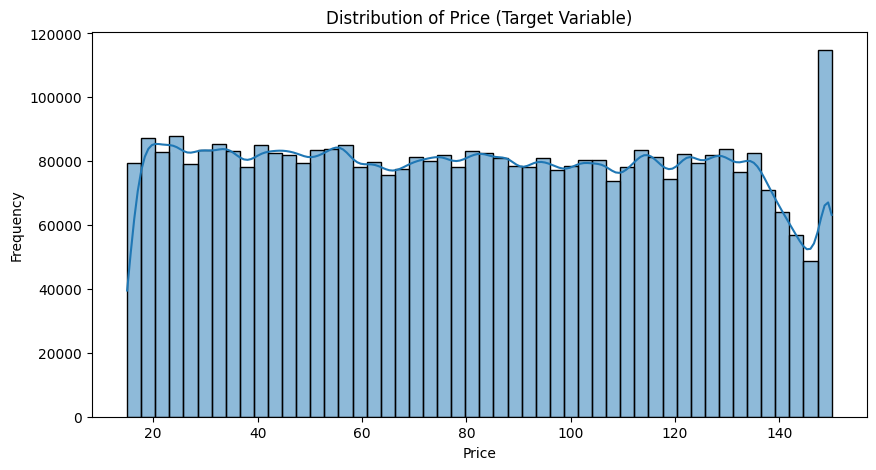

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(df_train["Price"], bins=50, kde=True)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of Price (Target Variable)")
plt.show()

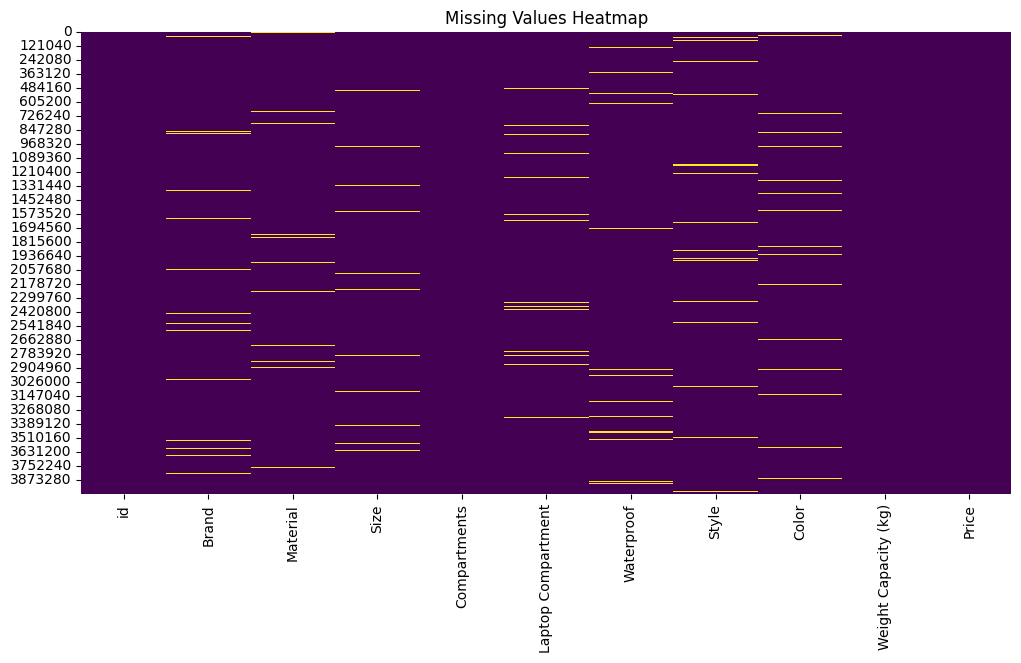

In [12]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


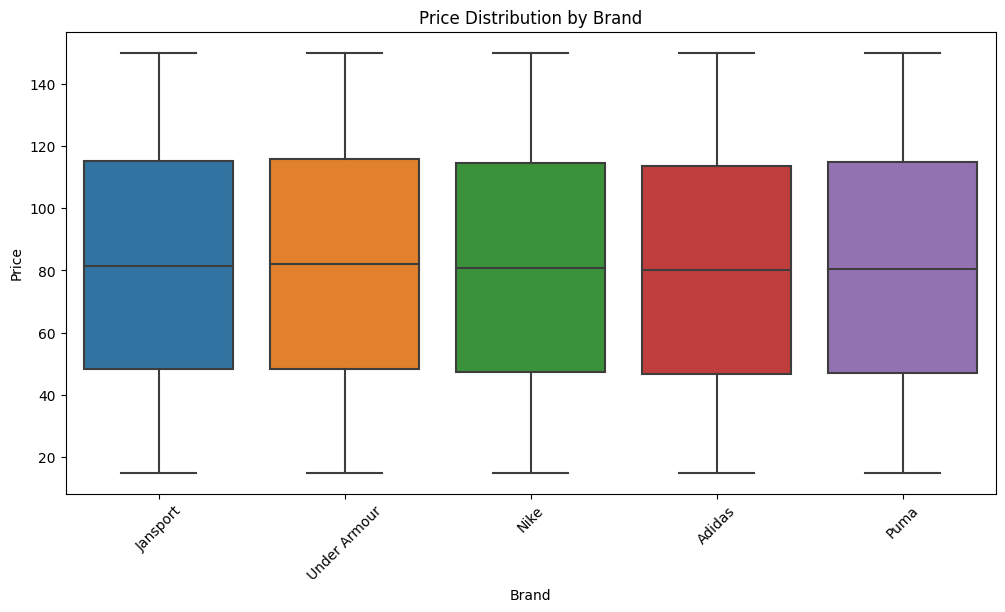

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Brand", y="Price", data=df_train)
plt.title("Price Distribution by Brand")
plt.xticks(rotation=45)
plt.show()


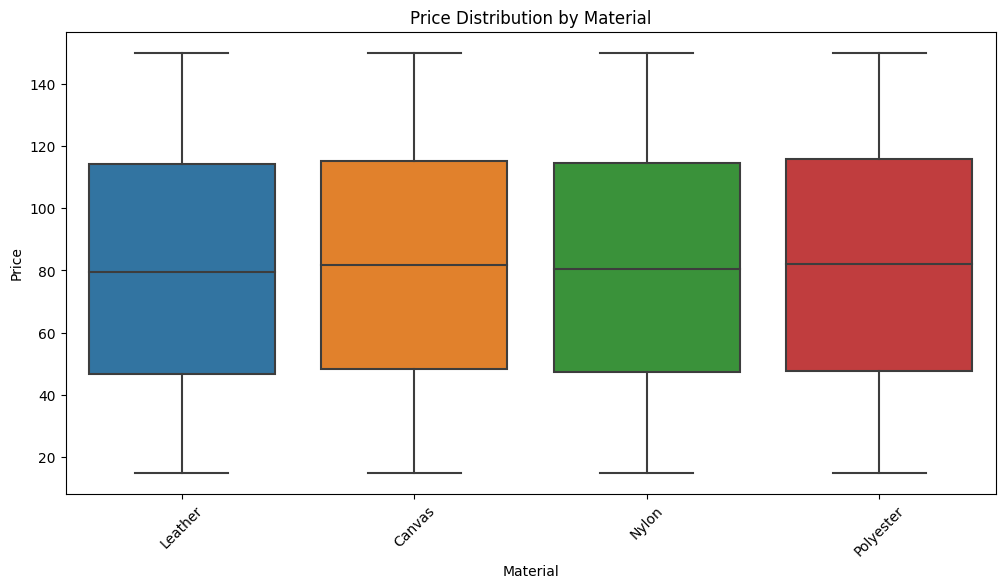

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Material", y="Price", data=df_train)
plt.title("Price Distribution by Material")
plt.xticks(rotation=45)
plt.show()


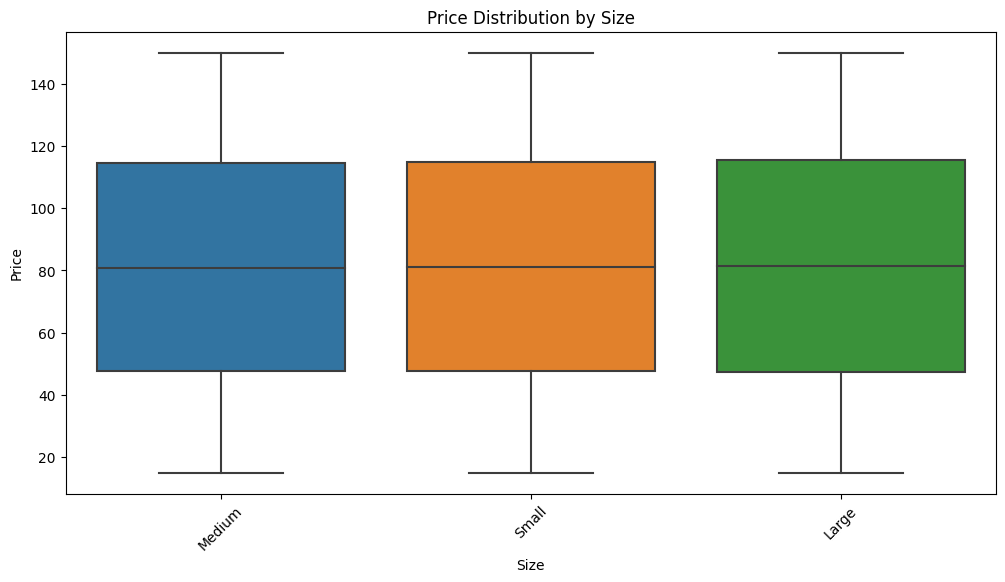

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Size", y="Price", data=df_train)
plt.title("Price Distribution by Size")
plt.xticks(rotation=45)
plt.show()


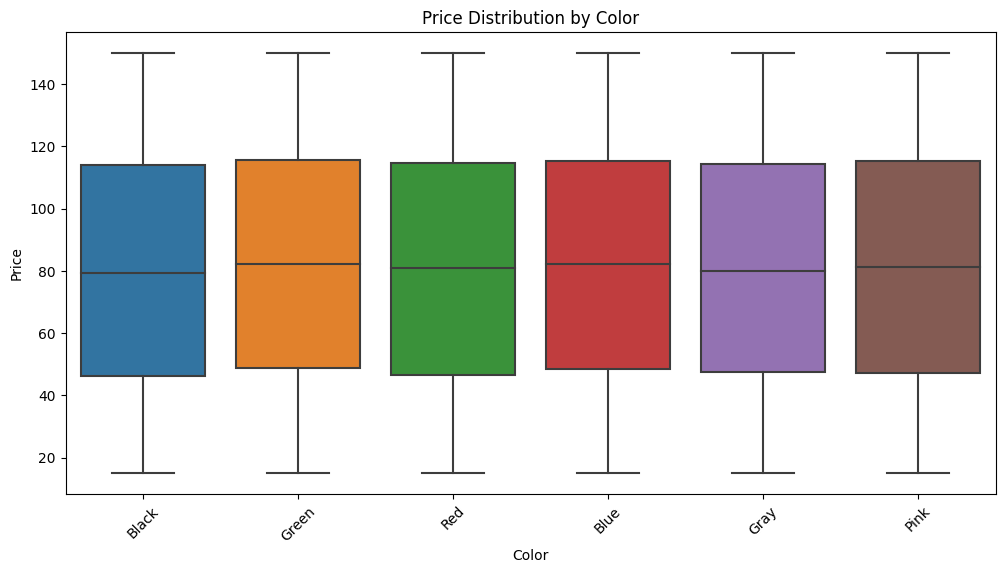

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Color", y="Price", data=df_train)
plt.title("Price Distribution by Color")
plt.xticks(rotation=45)
plt.show()


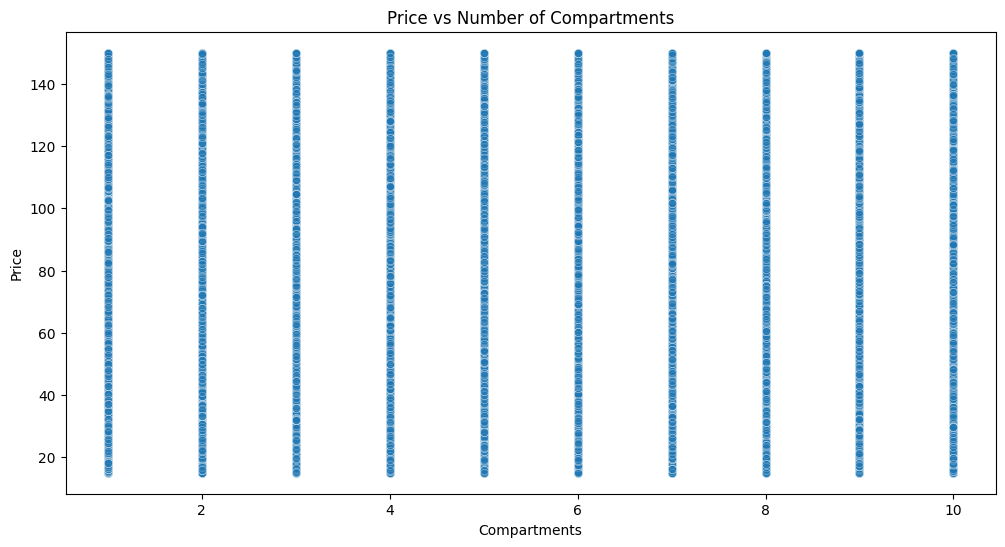

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="Compartments", y="Price", data=df_train, alpha=0.5)
plt.title("Price vs Number of Compartments")
plt.show()


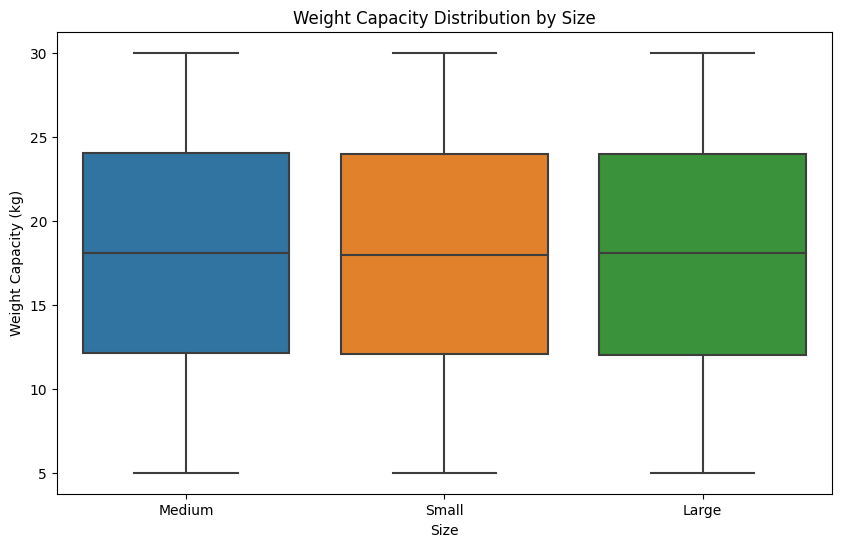

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Size", y="Weight Capacity (kg)", data=df_train)
plt.title("Weight Capacity Distribution by Size")
plt.show()


## **Data Imputation**

In [19]:
categorical_features = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]
numerical_features = ["Weight Capacity (kg)"]

for col in categorical_features:
    df_train[col].fillna(df_train[col].mode()[0], inplace=True)
    df_test[col].fillna(df_test[col].mode()[0], inplace=True)

for col in numerical_features:
    df_train[col].fillna(df_train[col].median(), inplace=True)
    df_test[col].fillna(df_test[col].median(), inplace=True)

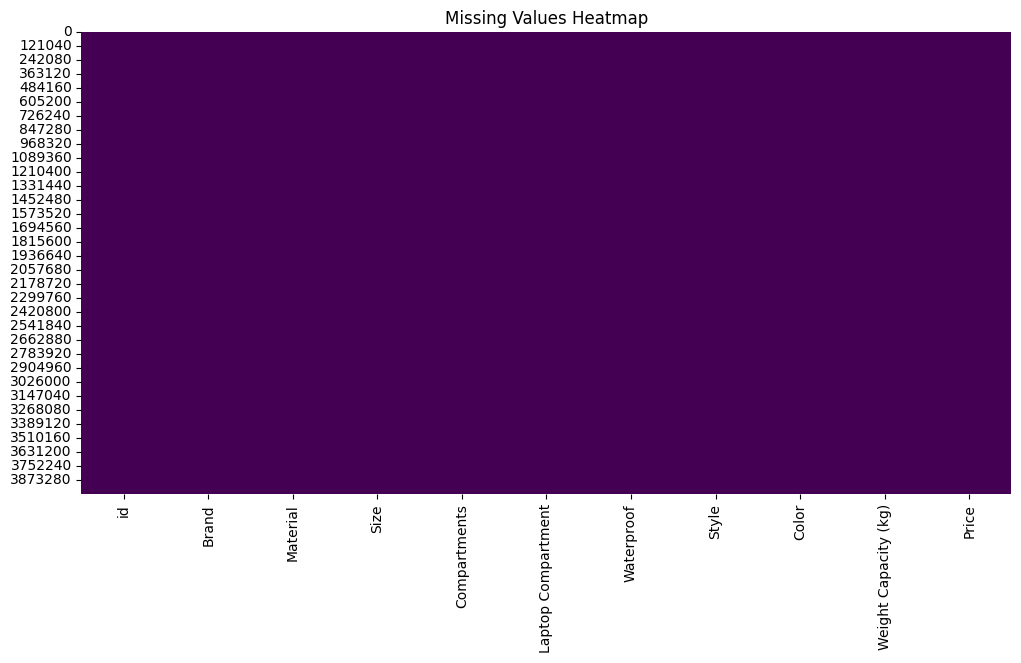

In [20]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

## **Encoding Categorical Features**

In [21]:
# One-Hot Encoding for categorical variables
one_hot_features = ["Brand", "Material", "Size", "Style", "Color"]
df_train = pd.get_dummies(df_train, columns=one_hot_features)

# Label Encoding for binary variables
binary_features = ["Laptop Compartment", "Waterproof"]
for col in binary_features:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])

## **Baseline Model - Linear Regression**

In [22]:
X = df_train.drop(columns=["Price", "id"])
y = df_train["Price"]


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("Baseline RMSE:", rmse)

Baseline RMSE: 38.89601974996219
